In [1]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import torchmetrics

/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


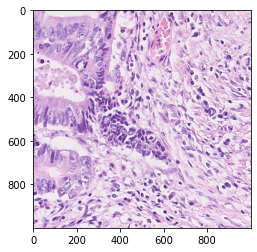

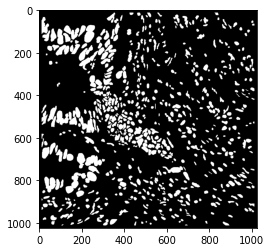

In [2]:
############################################
# Display Image and its corresponding Mask #
############################################
x = loadmat('/home/dkermany/data/CoNSeP/Train/Labels/train_1.mat')
img=mpimg.imread('/home/dkermany/data/CoNSeP/Train/Images/train_1.png')
imgplot = plt.imshow(img)
plt.show()
imshow(np.pad((x['inst_map']>=1).astype(int),12),cmap='gray')

In [3]:
class NucleiDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.img_ls = [image_path+i for i in sorted(os.listdir(image_path))]
        self.mask_ls = [ mask_path+i for i in sorted(os.listdir(mask_path))]
        self.transform = transform

    def __len__(self):
        return len(self.img_ls)

    def __getitem__(self, idx):
        img_name = self.img_ls[idx]
        img = Image.open(img_name).convert('RGB')
        img.load()
        mask_name = self.mask_ls[idx]
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)  
        if self.transform:
            img = self.transform(img)

        return img, mask


trans = transforms.Compose([
    transforms.Pad(12),    # given image is 1000x1000, pad it to make it 1024x1024
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet normalization
])

label_path = "/home/dkermany/data/CoNSeP/Train/Labels/"
img_path = "/home/dkermany/data/CoNSeP/Train/Images/"

train_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1  #my gpu is 8gb, using batchsize of 2 already insufficient memory, so i use batch size 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])


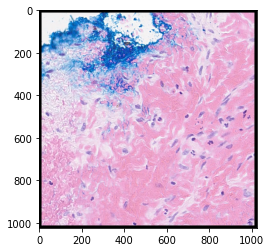

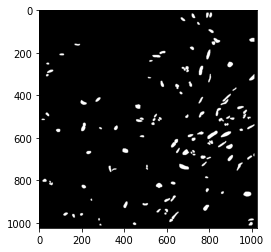

In [4]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


inputs, masks = next(iter(train_loader))

print(inputs.shape, masks.shape)  #shapes of our inputs to the model and loss function

plt.imshow(reverse_transform(inputs[0]))
plt.show()
imshow(masks[0],cmap='gray')

In [5]:
######################
# Model Architecture #
######################

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [6]:
###################################################################
# Loss function that combines Binary Cross Entropy with Dice loss #
###################################################################

# Model output is (N, 1, 1024,1024), where N = batch size, Thus you will see that i squeeze the 2nd dimension

def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

In [7]:
def iou(outputs, labels):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)
    
#     print("outputs",torch.unique(outputs))
#     print("labels",torch.unique(labels))
    
    intersection = (outputs & labels).float().sum((1,2))
    union = (outputs | labels).float().sum((1,2))
#     print(intersection, union)
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20. * (iou - 0.5), 0, 10).ceil() / 10.
    
    return thresholded

In [8]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    loss_ls = []
    acc_ls = []
    dice_ls = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        
        loss = 0
        acc = 0
        
        for inputs,masks in train_loader:
            model.train()
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            epoch_loss = weighted_loss(outputs,masks,bce_weight=0.3)
            epoch_loss.backward()
            optimizer.step()
            
            n_samples = len(inputs)
            loss+=(epoch_loss/n_samples).item()
            
            outputs_cpu = outputs.detach().to("cpu")[0][0]
            outputs_cpu[outputs_cpu>=0.95] = 1
            outputs_cpu[outputs_cpu<0.95] = 0

            acc += iou(outputs_cpu.int(), masks.int().detach().to('cpu'))

#             outputs = torch.squeeze(torch.argmax(outputs, dim=1))
#             masks = torch.squeeze(masks).int()
#             acc += (outputs == masks).all() / torch.numel(masks)
        
        loss /= len(train_loader)
        acc /= len(train_loader)
        print(f"epoch loss: {loss}, acc: {acc}")
        
        loss_ls.append(loss)
        acc_ls.append(acc)
        
        if (epoch+1)%5==0:
            print("\n","Input Image")
            plt.axis("off")
            plt.imshow(reverse_transform(inputs.to('cpu').detach()[0]))
            plt.show()
            print("Predicted Mask Binary")
            plt.axis("off")
            threshold=0.95    # vary the threshold
            pred = outputs.to('cpu').detach().numpy()[0][0]
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            plt.imshow(pred,cmap='gray')
            plt.show()
            print("Actual Mask")
            plt.axis("off")
            plt.imshow(masks.to('cpu').detach()[0],cmap='gray')
            plt.show()
        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),"\n")
    
    return loss_ls, acc_ls

cuda:0


/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dkermany/.local/share/virtualenvs/BoneSegmentation-C6QGg7XR/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/59
----------
epoch loss: 0.7006157967779372, acc: tensor([0.])
0m 4s 

Epoch 1/59
----------
epoch loss: 0.6012789099304764, acc: tensor([0.])
0m 4s 

Epoch 2/59
----------
epoch loss: 0.44770446861231766, acc: tensor([0.0444])
0m 4s 

Epoch 3/59
----------
epoch loss: 0.3694446710524736, acc: tensor([0.0926])
0m 4s 

Epoch 4/59
----------
epoch loss: 0.3348541353587751, acc: tensor([0.1630])

 Input Image


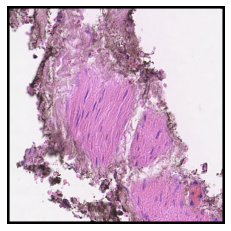

Predicted Mask Binary


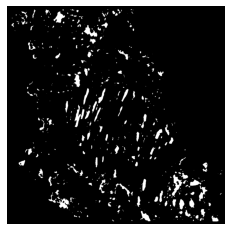

Actual Mask


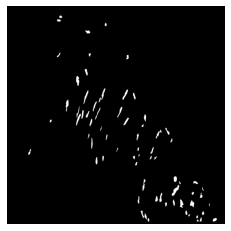

0m 4s 

Epoch 5/59
----------
epoch loss: 0.2877770402917155, acc: tensor([0.1963])
0m 4s 

Epoch 6/59
----------
epoch loss: 0.2866741369167964, acc: tensor([0.2519])
0m 4s 

Epoch 7/59
----------
epoch loss: 0.24868801291342135, acc: tensor([0.2630])
0m 4s 

Epoch 8/59
----------
epoch loss: 0.234852969094559, acc: tensor([0.3037])
0m 4s 

Epoch 9/59
----------
epoch loss: 0.21913736506744666, acc: tensor([0.3444])

 Input Image


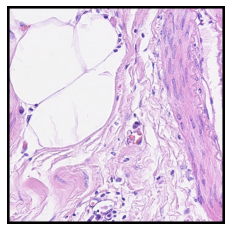

Predicted Mask Binary


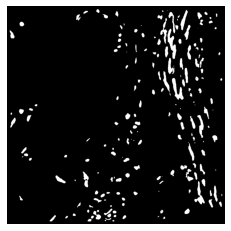

Actual Mask


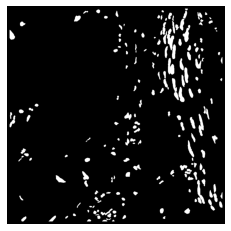

0m 4s 

Epoch 10/59
----------
epoch loss: 0.21213469378374242, acc: tensor([0.3704])
0m 4s 

Epoch 11/59
----------
epoch loss: 0.20452493649941902, acc: tensor([0.3815])
0m 4s 

Epoch 12/59
----------
epoch loss: 0.2048717933120551, acc: tensor([0.3889])
0m 4s 

Epoch 13/59
----------
epoch loss: 0.20630026470731805, acc: tensor([0.3852])
0m 4s 

Epoch 14/59
----------
epoch loss: 0.20497656944725248, acc: tensor([0.3815])

 Input Image


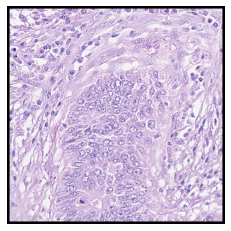

Predicted Mask Binary


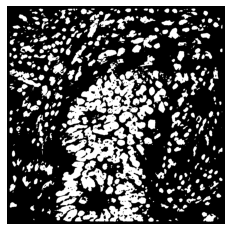

Actual Mask


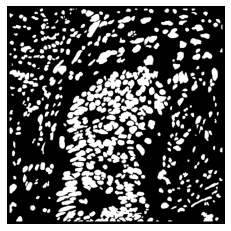

0m 4s 

Epoch 15/59
----------
epoch loss: 0.20096918471433498, acc: tensor([0.4074])
0m 4s 

Epoch 16/59
----------
epoch loss: 0.1908905737929874, acc: tensor([0.4333])
0m 4s 

Epoch 17/59
----------
epoch loss: 0.19168980971530633, acc: tensor([0.4259])
0m 4s 

Epoch 18/59
----------
epoch loss: 0.18864976559524183, acc: tensor([0.4296])
0m 4s 

Epoch 19/59
----------
epoch loss: 0.18073883652687073, acc: tensor([0.4556])

 Input Image


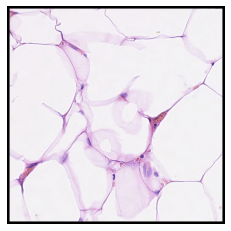

Predicted Mask Binary


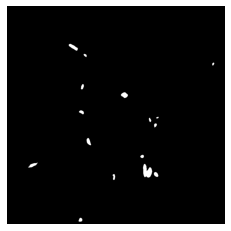

Actual Mask


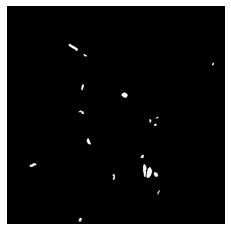

0m 4s 

Epoch 20/59
----------
epoch loss: 0.1767114696127397, acc: tensor([0.4704])
0m 4s 

Epoch 21/59
----------
epoch loss: 0.17598397257151427, acc: tensor([0.4556])
0m 4s 

Epoch 22/59
----------
epoch loss: 0.1761150978229664, acc: tensor([0.4593])
0m 4s 

Epoch 23/59
----------
epoch loss: 0.16933618955038213, acc: tensor([0.4815])
0m 4s 

Epoch 24/59
----------
epoch loss: 0.16548172136147818, acc: tensor([0.4889])

 Input Image


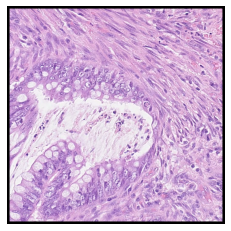

Predicted Mask Binary


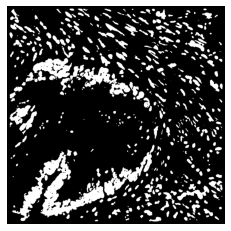

Actual Mask


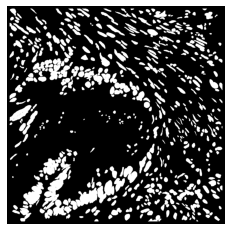

0m 4s 

Epoch 25/59
----------
epoch loss: 0.17286528840109153, acc: tensor([0.4741])
0m 4s 

Epoch 26/59
----------
epoch loss: 0.1726371325828411, acc: tensor([0.4815])
0m 4s 

Epoch 27/59
----------
epoch loss: 0.16579470838661547, acc: tensor([0.4963])
0m 4s 

Epoch 28/59
----------
epoch loss: 0.16891033809494088, acc: tensor([0.4926])
0m 4s 

Epoch 29/59
----------
epoch loss: 0.16478236461127246, acc: tensor([0.4926])

 Input Image


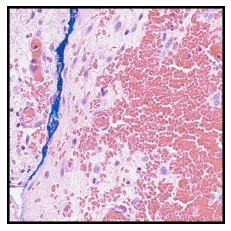

Predicted Mask Binary


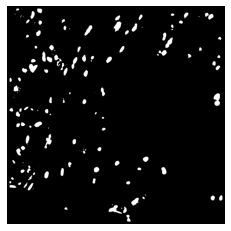

Actual Mask


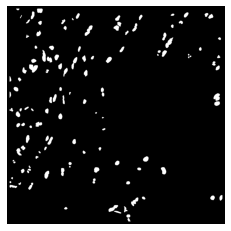

0m 4s 

Epoch 30/59
----------
epoch loss: 0.15671001650668956, acc: tensor([0.5148])
0m 4s 

Epoch 31/59
----------
epoch loss: 0.15305277622408336, acc: tensor([0.5370])
0m 4s 

Epoch 32/59
----------
epoch loss: 0.14871207624673843, acc: tensor([0.5519])
0m 4s 

Epoch 33/59
----------
epoch loss: 0.14615940964884228, acc: tensor([0.5593])
0m 4s 

Epoch 34/59
----------
epoch loss: 0.1471304711368349, acc: tensor([0.5556])

 Input Image


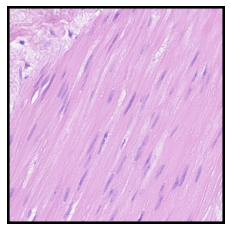

Predicted Mask Binary


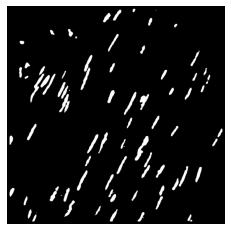

Actual Mask


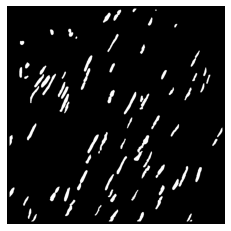

0m 4s 

Epoch 35/59
----------
epoch loss: 0.1471685372568943, acc: tensor([0.5519])
0m 4s 

Epoch 36/59
----------
epoch loss: 0.14950038575463825, acc: tensor([0.5481])
0m 4s 

Epoch 37/59
----------
epoch loss: 0.1458666851675069, acc: tensor([0.5556])
0m 4s 

Epoch 38/59
----------
epoch loss: 0.14015899722774824, acc: tensor([0.5741])
0m 4s 

Epoch 39/59
----------
epoch loss: 0.1399782250324885, acc: tensor([0.5741])

 Input Image


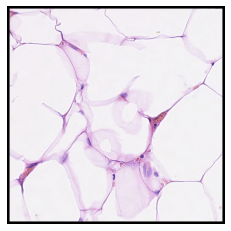

Predicted Mask Binary


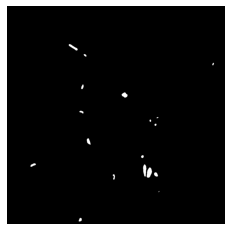

Actual Mask


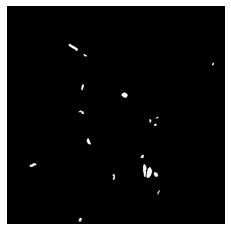

0m 4s 

Epoch 40/59
----------
epoch loss: 0.13610900455602892, acc: tensor([0.5852])
0m 4s 

Epoch 41/59
----------
epoch loss: 0.13606098666787148, acc: tensor([0.5852])
0m 4s 

Epoch 42/59
----------
epoch loss: 0.13674926730217757, acc: tensor([0.5889])
0m 4s 

Epoch 43/59
----------
epoch loss: 0.15256537855775268, acc: tensor([0.5333])
0m 4s 

Epoch 44/59
----------
epoch loss: 0.14079021027794592, acc: tensor([0.5815])

 Input Image


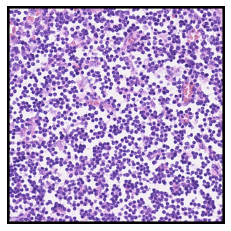

Predicted Mask Binary


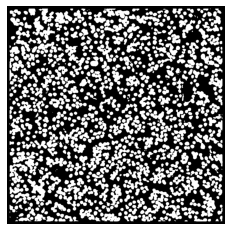

Actual Mask


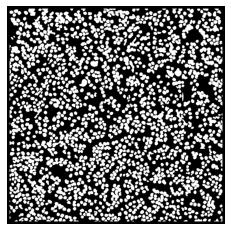

0m 4s 

Epoch 45/59
----------
epoch loss: 0.13139254103104273, acc: tensor([0.6000])
0m 4s 

Epoch 46/59
----------
epoch loss: 0.13061746375428307, acc: tensor([0.6000])
0m 4s 

Epoch 47/59
----------
epoch loss: 0.1351205935632741, acc: tensor([0.5926])
0m 4s 

Epoch 48/59
----------
epoch loss: 0.13181503034300274, acc: tensor([0.5926])
0m 4s 

Epoch 49/59
----------
epoch loss: 0.1253472806678878, acc: tensor([0.6185])

 Input Image


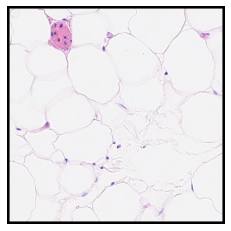

Predicted Mask Binary


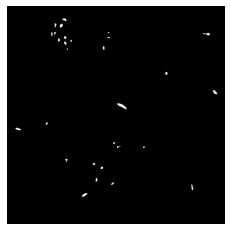

Actual Mask


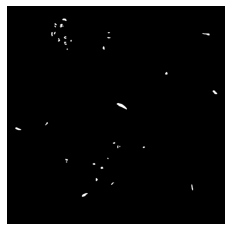

0m 4s 

Epoch 50/59
----------
epoch loss: 0.12957980980475745, acc: tensor([0.6074])
0m 4s 

Epoch 51/59
----------
epoch loss: 0.1248619379820647, acc: tensor([0.6296])
0m 4s 

Epoch 52/59
----------
epoch loss: 0.1208001830511623, acc: tensor([0.6333])
0m 4s 

Epoch 53/59
----------
epoch loss: 0.11801144867031663, acc: tensor([0.6333])
0m 4s 

Epoch 54/59
----------
epoch loss: 0.12299038318020326, acc: tensor([0.6259])

 Input Image


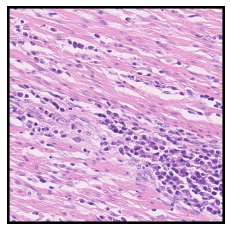

Predicted Mask Binary


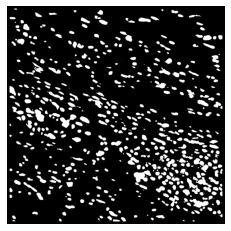

Actual Mask


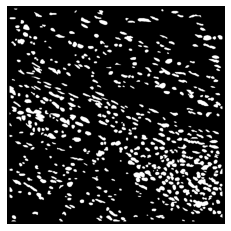

0m 4s 

Epoch 55/59
----------
epoch loss: 0.12389012370948438, acc: tensor([0.6333])
0m 4s 

Epoch 56/59
----------
epoch loss: 0.11956975015777128, acc: tensor([0.6333])
0m 4s 

Epoch 57/59
----------
epoch loss: 0.11179962409315286, acc: tensor([0.6667])
0m 4s 

Epoch 58/59
----------
epoch loss: 0.1085258200764656, acc: tensor([0.6667])
0m 4s 

Epoch 59/59
----------
epoch loss: 0.10965625169100585, acc: tensor([0.6778])

 Input Image


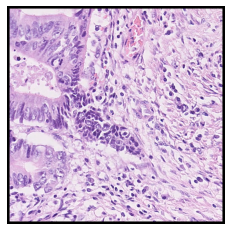

Predicted Mask Binary


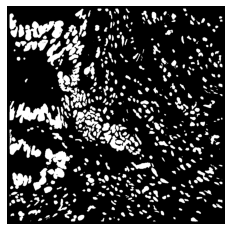

Actual Mask


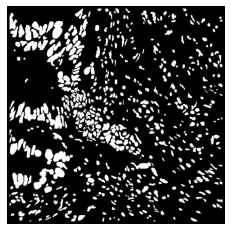

0m 4s 



In [9]:
#################
# Training Loop #
#################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)

params = {
    "num_classes": num_class,
    "mdmc_average": "global",
    "average": "micro",
    "multiclass": False,
}
# accuracy = torchmetrics.Accuracy(**params).to(device)
# dice = torchmetrics.Dice(**params).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

loss_ls, acc_ls = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [10]:
#######################
# Test Set Dataloader #
#######################

label_path = "/home/dkermany/data/CoNSeP/Test/Labels/"
img_path = "/home/dkermany/data/CoNSeP/Test/Images/"

test_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

Input Image


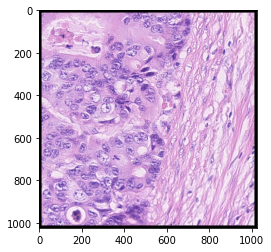

Predicted Mask Sigmoid


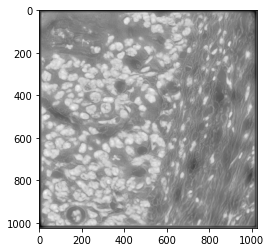

Predicted Mask Binary


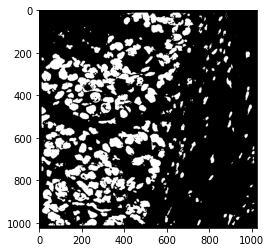

Actual Mask


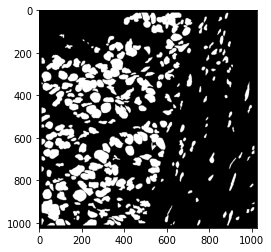

In [11]:
inputs, masks = next(iter(test_loader))
print("Input Image")
plt.imshow(reverse_transform(inputs[0]))
plt.show()
outputs = model(inputs.to(device))
pred = outputs.to('cpu').detach().numpy()[0][0]

print("Predicted Mask Sigmoid")
plt.imshow(pred,cmap='gray')
plt.show()
threshold=0.95    # vary the threshold
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
print("Predicted Mask Binary")
plt.imshow(pred,cmap='gray')
plt.show()
print("Actual Mask")
plt.imshow(masks[0],cmap='gray')
plt.show()

In [12]:
def eval_model(model):
    
    loss_ls = []
    acc_ls = []
    dice_ls = []
    
    loss = 0
    acc = 0

    for inputs,masks in test_loader:
        model.eval()
        inputs = inputs.to(device)
        masks = masks.to(device).float()

        outputs = model(inputs)

        batch_loss = weighted_loss(outputs,masks,bce_weight=0.3)

        n_samples = len(inputs)
        loss+=(batch_loss/n_samples).item()

        outputs_cpu = outputs.detach().to("cpu")[0][0]
        outputs_cpu[outputs_cpu>=0.90] = 1
        outputs_cpu[outputs_cpu<0.90] = 0

        acc += iou(outputs_cpu.int(), masks.int().detach().to('cpu'))
        
        loss /= len(test_loader)
        acc /= len(test_loader)
        
        loss_ls.append(loss)
        acc_ls.append(acc)
        
    print(f"Testing Loss: {loss}, IoU: {acc}")
    return loss_ls, acc_ls

In [13]:
#################
# Eval Loop #
#################

loss_ls, acc_ls = eval_model(model)

RuntimeError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 23.69 GiB total capacity; 7.83 GiB already allocated; 247.62 MiB free; 9.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF